In [173]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import math
import matplotlib.pyplot as plt
# from numba import int32, float32    # import the types
# from numba import jitclass, types, typed

# # key and value types
# kv_ty = (types.int64, types.unicode_type)


"""
_______________________________________________________________________________________________
"""

class GrowthFunction:
    def __init__(self, h=0.73, omega_m=0.27,omega_l=0.73):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.H_0=((h*100*u.km*u.s**-1*u.Mpc**-1).to(u.Gyr**-1)).value
        self.h=h
    
    """
    We need to create a growth factor function. Which depends on the cosmological model.
    1) find the evolution of the densities
    2) define the growth factor
    """

    def Time(self, z):
        return 2/3/(1+z)**(3/2)/self.H_0

    #hubble
    def E_of_z(self, redshift):
        """
        E(z) which describe the evolution of H(z)=E(z)*H0
        """
        Ez = (self.omega_l0 + (1.0 - self.omega_l0 
            - self.omega_m0) * (1.0+redshift)**2 
            + self.omega_m0 * (1.0+redshift)**3)**(1/2)

        return Ez

    #matter
    def omega_mz(self,redshift):
        return self.omega_m0 * (1.0+redshift)**3 / self.E_of_z(redshift)**2.0

    #Vacuum
    def omega_lz(self,redshift):
        return self.omega_l0 / (self.E_of_z(redshift))**2

    def g_of_z(self, redshift):
        """
        growth linear factor
        """

        gz = 2.5 * self.omega_mz(redshift) / (self.omega_mz(redshift)**(4/7) 
        - self.omega_lz(redshift) + ((1 + self.omega_mz(redshift)/2) 
        * (1 + self.omega_lz(redshift)/70)))

        return gz

    def D_of_z(self, redshift):
        """
        growth function
        """
        return self.g_of_z(redshift) / self.g_of_z(0.0) / (1.0+redshift)
    
    def Delta_c(self, redshift):
        return 1.686/self.D_of_z(redshift)


"""
_______________________________________________________________________________________________
"""

class Overdensities:
    
    def __init__(self,redshift=0,h7=1.05,h=0.73,omega_m=0.27,omega_l=0.73, ns=0.95,sigma8=0.8,Nbins_Sigma=50,logmass_lim=(4, 20)):

        if (h<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h should be in units of 100 km/s/Mpc.\n")
        if (h7<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h7>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h7 should be in units of 70 km/s/Mpc.\n")
        if (redshift<=-1.0):
            raise ValueError("Overdensities(): Redshift < -1 is illegal.\n")
        elif (redshift>4000.0):
            raise ValueError("Overdensities(): Large redshift entered.  TF may be inaccurate.\n")

        Growth = GrowthFunction(omega_m = omega_m, omega_l = omega_l)

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.h7=h7
        self.h=h
        self.Nbins_Sigma = Nbins_Sigma
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.rho_0 =133363631951.67577
        #WMAP pivot scale
        self.kpivot = 2e-3

        self.D_of_z = Growth.D_of_z
        self.g_of_z = Growth.g_of_z

        #Normalization of the power spectrum
        self.N=1
        self.N=sigma8*sigma8 / (self.Sigma_of_R(self.TopHatFilter, 11.4))**2
        

        # output arrays
        # Smother radius [Mpc/h]
        self.R = np.empty(self.Nbins_Sigma,dtype='float64')
        # mass (M_sun/h)
        self.M = np.empty(self.Nbins_Sigma,dtype='float64')
        self.logM = np.empty(self.Nbins_Sigma,dtype='float64')
        #self.M = np.logspace(self.logmass_min, self.logmass_max, self.Nbins_Sigma)
        # sigma(M, z=0, where mass is in [M_sun/h])
        # array of sigma for three different filters
        self.Sigmas = np.empty(3, dtype=object)
        self.Sigmasz = np.empty(3, dtype=object)
        self.interpolates = np.empty(3, dtype=object)

        #we can initialize sigma(M) for the different filter to then interpolate
        self.Filters = (self.TopHatFilter, self.GaussianFilter, self.KSharpFilter)
        self.Ints = np.empty(3, dtype=object)

        for i in range(3):

            s, self.R = self.SigmaM_Array(self.Filters[i])
            self.Sigma = s
            self.Sigmas[i] = s
            sz = self.SigmaM_of_z()
            self.Sigmaz = sz
            self.Sigmasz[i] = sz
            interpolate = self.Interpolator()
            self.interpolates[i] = interpolate
            int = self.Sigma_of_M_and_z(self.M, interpolate)
            self.Ints[i] = int

    """
    Main function 
    Change filter if needed (self.GaussianFilter <-> self.KSharpFilter <-> self.TopHatFilter)
    _______________________________________________________________________________________________
    """
    def S(self, m):
        s = np.vectorize(self.S_prep)
        return s(m)

    def S_Z(self, m, z):
        sz = self.D_of_z(z)*self.S(m)
        return sz

    def S_Z_interpolate(self, m, z, interpolate):
        return self.D_of_z(z)*interpolate(np.log10(m))


    """
    _______________________________________________________________________________________________
    """

    
    def S_prep(self, m):
        gamma_f, c = (2*np.pi)**(2/3), 0.643
        R = c*(m/(gamma_f*self.rho_0))**(1/3)
        s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]
        return (s/(2*np.pi**2))**(1/2)

    def TransferFunction(self, k):
        q=2.04/(self.omega_m0*self.h7**2)
        return np.log(1+2.34*q*k)/(2.34*q*k*(1+3.89*q*k+(16.1*q*k)**2+(5.46*q*k)**3+(6.71*q*k)**4)**(1/4))
    
    def PowerSpectrum(self, k):
        return self.N * self.TransferFunction(k)**2 * k * (k/self.kpivot)**(self.ns-1)
    
    """
    Now we define each filters. 
    Using the series expansion at low Rk make the integration more precised (for numerical integration).
    """

    def TopHatFilter(self, x):
        if x < 1e-2:
            return 1-x**2/10+x**4/280
            # return 1./3. - x**2/30. +x**4/840
        else:
            return 3/(x)**3*(np.sin(x)-x*np.cos(x))
        
    def GaussianFilter(self, x):
        if x < 1e-2:
            return 1-x**2/2+x**4/8
        else:
            return np.exp(-x**2/2)
        
    def KSharpFilter(self, x):
        if x <= 1:
            return 1
        else:
            return 0
    
    def integrant(self, k, R, Filter):
        return k**2*self.PowerSpectrum(k)*Filter(k*R)**2
    
    def Sigma_of_R(self, Filter, R):

        s2 = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter), epsrel=1e-2, limit=100)[0]
        
        return (s2/(2*np.pi**2))**(1/2)

    def Sigma_of_M(self, Filter, M):

        if Filter == self.TopHatFilter:
            gamma_f, c = 4*np.pi/3, 1
        
        elif Filter == self.GaussianFilter:
            gamma_f, c = (2*np.pi)**(2/3), 0.643
        
        elif Filter == self.KSharpFilter:
            gamma_f, c = 6*np.pi**2, 1

        R = c*(M/(gamma_f*self.rho_0))**(1/3)

        s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]

        return (s/(2*np.pi**2))**(1/2), R
    
    def SigmaM_Array(self, Filter):
        
        s = np.empty(self.Nbins_Sigma, dtype='float64')
        R = np.empty(self.Nbins_Sigma, dtype='float64')

        dm = (self.logmass_max - self.logmass_min)/self.Nbins_Sigma

        for i in range(self.Nbins_Sigma):

            logM = self.logmass_min + i*dm

            M = 10.0**logM

            s[i], R[i]= self.Sigma_of_M(Filter, M)

            self.M[i] = M

            self.logM[i] = logM

        return s, R


    """The final function is ready to be set up"""

    def Interpolator(self):
        return scipy.interpolate.InterpolatedUnivariateSpline(self.logM, self.Sigma)

    def SigmaM_of_z(self):
        sz = self.D_of_z(self.redshift)*self.Sigma
        return sz

    def Sigma_of_M_and_z(self, M, interpolate):
        return self.D_of_z(self.redshift)*interpolate(np.log10(M))

"""
_______________________________________________________________________________________________
"""

class HaloMassFunction:

    def __init__(self, redshift, omega_m=0.27, omega_l=0.73, h=1.05, ns=0.95, sigma8=0.8, mass_function=None, Nbins=50, logmass_lim=(6, 20)):
        self.overden = Overdensities(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins_Sigma=Nbins, logmass_lim=logmass_lim)
        self.logM=self.overden.logM
        self.M = self.overden.M
        self.interpolates=self.overden.interpolates

        if mass_function == None:
            self.mass_function = self.press_schechter
        else:
            self.mass_function = mass_function.__get__(self)

        self.redshift = redshift
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c

        self.S = self.overden.S

        self.dndms=np.empty(3, dtype=object)

        for i in range(3):

            dndm=self.dndm_gen(self.M, self.interpolates[i])

            self.dndms[i] = dndm

    """
    Main function 
    _______________________________________________________________________________________________
    """
    def IMF(self, m, z):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative(m)
        mass_func = self.press_schechter_z(sigma, z)
        
        IMF = np.abs(dlogsigma)*mass_func/m*rho_0

        return IMF
    """
    _______________________________________________________________________________________________
    """

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(M**1.1)
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma

    def logderivative_filter(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.1*np.log10(M))
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma
        
    
    def dndm_gen(self, M, interpolate):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative_filter(M, interpolate)
        mass_func = self.mass_function(sigma)
        
        dndM =  np.abs(dlogsigma)*mass_func/M*rho_0

        return dndM

    def press_schechter_z(self, sigma, z):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(z) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def press_schechter(self, sigma):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(self.redshift) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eq. 6"""
        nu = self.Delta_c(self.redshift) / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def watson_FOF(self, sigma):
        """Watson 2012, eq. 12"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

"""
_______________________________________________________________________________________________
"""


class MergerRate:
    def __init__(self, redshift, redshift_lim = (0, 12), M_1=5e13, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8, Nbins=50, logmass_lim=(6, 20)):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.logmass_lim = logmass_lim
        self.sigma8 = sigma8
        self.h=h
        self.Nbins = Nbins
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.M_1=M_1
        self.redshift_max_lim = redshift_lim[1]
        self.redshift_min_lim = redshift_lim[0]
        #self.rho_0 =133363631951.67577


        self.HMF = HaloMassFunction(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins=Nbins, logmass_lim=logmass_lim)
    
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c
        self.Time = Growth.Time

        overden = Overdensities(0, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        self.S=overden.S



    """Create a merger rate at a fixed final mass in terms of the redshift"""

    def MergerRate_M_Z(self, M2, M1, Z):

        der, sigma2 = self.logderivative(M2)
        sigma1 = self.S(M1)

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MergerRate_M_Z2(self, M2, M1, Z):

        interpolate = self.overden.interpolates[1]

        der, sigma2 = self.derivative2(M2, interpolate)
        sigma1 = interpolate(np.log10(M1))

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR


    """Create a merger rate at a fixed redshift in terms of the mass"""
    def MergerRate_of_M2(self):
        
        overden = Overdensities(self.redshift, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        interpolate = overden.interpolates[1]

        DeltaM = np.empty(self.Nbins, dtype=object)
        LogdeltaM = np.empty(self.Nbins, dtype=object)

        MR = np.empty(self.Nbins, dtype=object)

        logDMmin = -2
        logDMmax = 2
        sigma1 = interpolate(np.log10(self.M_1))
        dlogm = (logDMmax-logDMmin)/self.Nbins

        for i in range(self.Nbins):

            thislogDM = logDMmin + i*dlogm
            thisDM = 10**(thislogDM)*self.M_1
            thisM2 = thisDM + self.M_1

            der , sigma2 = self.logderivative2(thisM2, interpolate)

            MR[i] = 3/1e-3*(2/np.pi)**(1/2)/self.Time(self.redshift)*2/3*thisDM/thisM2*np.abs(der)*self.Delta_c(self.redshift)/sigma2/(1-(sigma2/sigma1)**2)**(3/2)*np.exp(-0.5*self.Delta_c(self.redshift)**2*(1/sigma2**2-1/sigma1**2))
            DeltaM[i] = thisDM
            LogdeltaM[i] = thislogDM

        return MR, DeltaM, LogdeltaM

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(1.00000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma

            
    def logderivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.1*M))
        return (np.log(sigma_plus)-np.log(sigma))/np.log(0.1*M), sigma
    
    def derivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.00000000001*M))
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma
    
    def Delta_c_derivative(self, z):
        DT = self.Delta_c(z)
        DTplus = self.Delta_c(1.0001*z)
        return (DTplus-DT)/0.0001*z

In [185]:
from scipy.stats import norm
class MergerTree:

    def __init__(self, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(4, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

    def MT_Routine(self, M0, z0, Ml):

        Ms = []
        z_m=z0
        DM=M0
        
        i=0

        while DM>Ml:

            sigma_c = self.Delta_c(z_m)
            M_c = self.M_finder(sigma_c**(-3/2)*DM, sigma_c)

            domegaC = self.OmegaStep(DM, DM-M_c)

            M, domega = self.M_picker(DM, domegaC)

            z_m = self.z_finder(z_m, domega)

            DM=DM-M

            if M>Ml:
                Ms.append(M)
                i+=1
                
            if i==2:
                break
            
        M_acc = M0-np.sum(np.array(Ms))

        return Ms, z_m, M_acc


    def M_picker(self, M0, domegaC):
        i=0

        while i<1:

            domega = np.random.uniform(0, domegaC)

            x_output = np.random.normal(0,1)

            dS = (domega/(2*x_output))**2
            S = self.sigma_int(M0)+dS

            if S<10.364915262606484:

                M_output = self.M_finder(M0, S)

                if M_output<M0:
                    i+=1

        # print(M_output,  'z=', self.z_finder(z0, domega), 'from z_0=', z0)
        return M_output,  domega

    def M_finder(self, M0, sigma):
        return float(scipy.optimize.fsolve(self.S_for_M, M0, args=sigma))
        
    def S_for_M(self, M, sigma_MF):
        return self.sigma_int(M)-sigma_MF
    
    def derivative(self, M):
        sigma = self.sigma(M)
        sigma_plus = self.sigma(1.000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.000000001*M)
    
    def z_finder(self, z_0, domega):
        Df = self.Delta_c(z_0)+domega
        return float(scipy.optimize.fsolve(self.Delta_c_for_z, z_0, args=Df))

    def Delta_c_for_z(self, z, D_z_f):
        return self.Delta_c(z)-D_z_f

    def OmegaStep(self, M0, dMc):
        return np.sqrt(np.abs(self.derivative(M0))*dMc)

In [187]:
z=np.linspace(0, 30, 100)
MT = MergerTree()
sigma_star = MT.Delta_c(z)/3
M = np.zeros(len(z))
for i in range(len(M)):
    M[i] = np.log10(MT.M_finder(10**(4), sigma_star[i]))


<ipython-input-173-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


(0.0, 30.0)

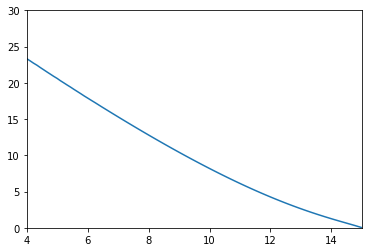

In [188]:
plt.plot(M, z)
plt.xlim(4, 15)
plt.ylim(0, 30)

In [189]:
MT = MergerTree()
ml= 1e6
for i in range(20):
    Ms, zs, M_acc = MT.MT_Routine(1e12, 10, ml)
    print(np.sum(Ms)+M_acc)
    print(Ms, M_acc, zs)

<ipython-input-173-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


1000000000000.0
[791602689247.7816, 118211770596.09863] 90185540156.11975 11.90773654445816
1000000000000.0
[784298882758.3357, 146099034961.94235] 69602082279.72192 11.373559693359681
1000000000000.0
[969827414724.9105, 19530967547.23342] 10641617727.85608 11.206897099621234
1000000000000.0
[878828970444.0586, 113019643213.69592] 8151386342.245483 10.596220103290719
1000000000000.0
[869732768095.7257, 84278161394.11543] 45989070510.15881 11.526454269609511
1000000000000.0
[969133517756.9169, 30472719157.290627] 393763085.79248047 10.409953015703222
1000000000000.0
[948310170071.0533, 32946416707.59322] 18743413221.353394 10.797633546093207
1000000000000.0
[965538139055.855, 17179231779.06318] 17282629165.081787 11.194463643847868
1000000000000.0
[562706075605.623, 298993775838.21985] 138300148556.1571 11.119661633911628
1000000000000.0
[734535573685.9246, 192251073003.00897] 73213353311.0664 10.775631497694294
1000000000000.0
[763004332153.1049, 168170235475.90356] 68825432370.99158 1

In [236]:
from itertools import chain

mfinder = np.vectorize(MT.M_finder)

def HalosGenerator(ninput, z):
    r = np.random.uniform(0, 1, ninput)
    y = MT.Delta_c(z)/(np.sqrt(2))/scipy.special.erfinv(r)
    M=mfinder(1e4, y)
    return M

In [237]:
n_halos=1000

Halos = HalosGenerator(n_halos, 10)

/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [246]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 18, 100)
Himf_10 = HIMF.IMF(m, 10)/scipy.integrate.quad(HIMF.IMF, 10**4, 10**10, args=10, limit= 100)[0]

<ipython-input-173-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
<ipython-input-246-27a511d52802>:3: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Himf_10 = HIMF.IMF(m, 10)/scipy.integrate.quad(HIMF.IMF, 10**4, 10**10, args=10, limit= 100)[0]


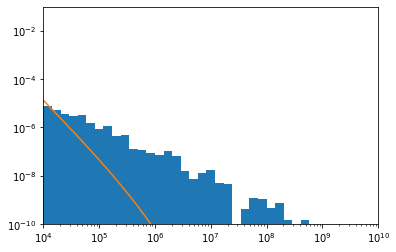

In [247]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 10, 40))
M=np.logspace(4, 10, 100)
plt.plot(M, Himf_10)
plt.xlim(10**4, 10**10)
plt.ylim(1e-10,1e-1)

plt.xscale('log')
plt.yscale('log')

In [224]:
z=10
ml = 1e4
while z<20:
    Mss=[]
    Z=[]
    for ii in range(len(Ms)):
        routine = MT.MT_Routine(Ms[ii], z , ml)
        Z.append(routine[1])
        Mss.append(routine[0])
    z=np.max(Z)
    print(z)

    Mss = list(chain.from_iterable(Mss))
    Ms = Mss
    print(Ms)

/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


15.711087951879978
[1176307.9872950746, 2223418.748230089, 56814.90316708553, 15064471.582855009, 8268480.492140105, 22230.696953321138, 26510.90199632556, 37322.84797278435, 37720.941651468005, 16430.287808743065, 14655.530131719608, 58523.7980705859, 228407.5591795001, 137112.8988744895, 33574.85449069725, 548548.7419663791, 7690680.8853598405, 322415.33270298486, 3358151.5239461497, 523273.2455461319, 457635.7194232593, 19959620.89949004, 3718982.3450205945, 9850500.263909046, 3581961.060319931, 43160.05108120456, 40798.3614933798, 30267.46951673529, 13882.767461770824, 33371604.759809904, 691704.670359131, 3908489.7498292006, 1322703.3505259492, 11389.892876320451, 352660.2968274472, 157491.63804639145, 60067.62217608097, 10138.913083717502, 34320.854667373336, 87296.06080069892, 56612.23540897282, 10117.232323478998, 28604.718655516946, 361726.1787684204, 44696.492568199064, 1121931.9761488321, 90713.70273351818, 2195659675.4959335, 1169892512.002701, 69395488.4551111, 20981524.24

In [222]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 18, 100)
Himf = HIMF.IMF(m, 30)/scipy.integrate.quad(HIMF.IMF, 10**4, 10**9, args=30)[0]

<ipython-input-173-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
<ipython-input-222-ffd9ef17049c>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Himf = HIMF.IMF(m, 30)/scipy.integrate.quad(HIMF.IMF, 10**4, 10**9, args=30)[0]


(10000.0, 1000000000.0)

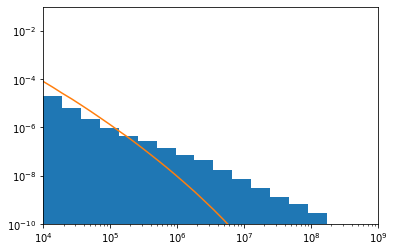

In [226]:
plt.hist(Ms, bins=10**np.linspace(4,15,40), density=True)
plt.plot(m, Himf)
plt.ylim(1e-10,1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 1e9)